
# Simple emulator


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Setup


In [9]:
from sklearn.pipeline import Pipeline

def L(X):
    return f(X[:,0], X[:,1])

class regression:
    def __init__(self, X, y, degree=3):
        self.degree=degree
        self.model = LinearRegression().fit(self._transform_X(X), y)
    
    def _transform_X(self,X):
        poly = PolynomialFeatures(degree=self.degree)
        return poly.fit_transform(X)
    
    def __call__(self,X):
        return self.model.predict(self._transform_X(X))

In [10]:
def initial_sample(n=2, N=10):
    X = np.empty((N,n))
    base = np.linspace(0,1,N)
    for i in range(n):
        np.random.shuffle(base)
        X[:,i] = base
    return X

In [11]:
X = initial_sample()

## "No regression" emulator

In [13]:

def arr(x):
    return np.array(x)

def _get_size(x, D):
    try:
        size = len(x)
    except TypeError:
        size = 1
    
    n_D = D.size
    return size, n_D    

beta = 0.5
sigma = 0.6
theta = 0.06
sigma2 = sigma**2
theta2 = theta**2


def L(x):
    return 3*x *np.sin(5*np.pi*(x-0.1)/0.4)

xi = np.array([[0.25],[0.5]])
D = L(xi)

def p_E_f(x):
     # here we would add the regression, but without it, a constant is enough
    
    return np.ones((x.shape[0],1))*beta

def p_Var_f(x):

    if len(x.shape)==1:
        x = x[:,np.newaxis]
    size, n_pars = x.shape
    return sigma2*np.ones((size,1))

def p_E_D(x,D):
    return beta*np.ones((D.size, 1))

def p_cov_f_D(x,xi):
    
    if len(x.shape)==1:
        x = x[:,np.newaxis]
    
    if len(xi.shape)==1:
        xi = xi[:,np.newaxis]
        
    size, n_pars = x.shape
    n_D, n_pars2 = xi.shape
    assert n_pars == n_pars2
    
    cov = np.ones((size, n_D))*sigma
    for i in range(size):
        for j in range(n_D):
            d = x[i,:]-xi[j,:]
            d2 = d @ d
            cov[i,j] = sigma2 * np.exp(-d2/theta2)
    return cov

def p_Var_D(xi):
    return p_cov_f_D(xi,xi)   

def adj_E(x, xi, D):
    inv_VD = np.linalg.inv(p_Var_D(xi))
    return p_E_f(x) + (p_cov_f_D(x, xi) @ inv_VD) @ (D-p_E_D(x,D))
    
def adj_Cov(x, xi, D):    
    inv_VD = np.linalg.inv(p_Var_D(xi))
    cov_f_D =  p_cov_f_D(x,xi)
    cov_D_f = cov_f_D.T
    print(cov_f_D.shape)
    print(inv_VD.shape)
    print(cov_D_f.shape)
    adj = cov_f_D @ inv_VD @ cov_D_f
    return p_Var_f(x) - adj.diagonal()[:,np.newaxis]

In [14]:


inv_VD = np.linalg.inv(p_Var_D(xi))
cov_f_D =  p_cov_f_D(x,xi)
cov_D_f = cov_f_D.T
print(cov_f_D.shape)
print(inv_VD.shape)
print(cov_D_f.shape)
adj = cov_f_D @ inv_VD @ cov_D_f


(15, 2)
(2, 2)
(2, 15)


In [15]:

x = np.array([0.2,0.3,0.4])[:,np.newaxis]
print('p_E_f(x).shape', p_E_f(x).shape)
print('p_Var_D(xi).shape', p_Var_D(xi).shape)
print('p_Var_f(xi).shape', p_Var_f(x).shape)
print('p_cov_f_D(x, xi).shape', p_cov_f_D(x, xi).shape)
print('(D-p_E_D(x,D))', (D-p_E_D(x,D)).shape)
print('adj_E(x,xi, D).shape', adj_E(x,xi, D).shape)
print('adj_Cov(x,xi, D).shape', adj_Cov(x,xi, D).shape)

p_E_f(x).shape (3, 1)
p_Var_D(xi).shape (2, 2)
p_Var_f(xi).shape (3, 1)
p_cov_f_D(x, xi).shape (3, 2)
(D-p_E_D(x,D)) (2, 1)
adj_E(x,xi, D).shape (3, 1)
(3, 2)
(2, 2)
(2, 3)
adj_Cov(x,xi, D).shape (3, 1)


(100, 6)
(6, 6)
(6, 100)


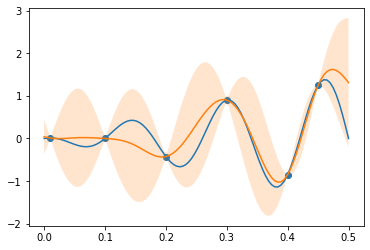

In [16]:
t = np.linspace(0,0.5,100)
xi = arr([0.01,0.1, 0.2, 0.3, 0.4,0.45])
D = L(xi)[:,np.newaxis]
plt.plot(t, L(t))
plt.scatter(xi, D)
aE = adj_E(t, xi, D)
aCov = np.sqrt(adj_Cov(t, xi, D))

plt.plot(t, aE)
plt.fill_between(t, y2=(aE+3*aCov).ravel(), y1=(aE-3*aCov).ravel(),alpha=0.2)

In [17]:
def f(X):
    x = 2*X[...,0]-1
    y = 2*X[...,1]-1
    r = (np.exp(-((x+.2)**2+2*(y+.2)**2+x*y*0.8)/.32) 
         + np.exp(-((x-.2)**2+(y-.4)**2)/.17))
    return r.reshape(x.shape)


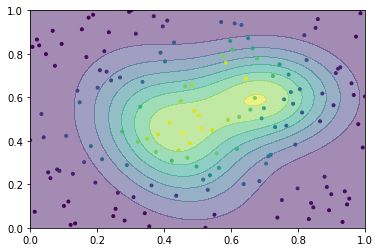

In [18]:
def initial_sample(n_params=2, N_samples=2):
    X = np.empty((N_samples,n_params))
    base = np.linspace(0,1,N_samples)
    for i in range(n_params):
        np.random.shuffle(base)
        X[:,i] = base
    return X

Xi = initial_sample(N_samples=150)
D = f(Xi)[:,np.newaxis]

t = np.linspace(0,1,100)
Xt = np.vstack([[*np.meshgrid(t,t)]]).T
plt.contourf(t,t,f(Xt),alpha=0.5)
plt.scatter(Xi[:,0],Xi[:,1], c=f(Xi), marker='.')

In [19]:
X = Xi[:3,:]
print('D.shape', D.shape)
print('X.shape', X.shape)
print('Xi.shape', Xi.shape)
print('p_E_f(X).shape', p_E_f(X).shape)
print('p_Var_D(xi).shape', p_Var_D(Xi).shape)
print('p_cov_f_D(x, xi).shape', p_cov_f_D(X, Xi).shape)
print('(D-p_E_D(x,D))', (D-p_E_D(X,D)).shape)
print('p_E_D(x,D)', p_E_D(X,D).shape)
print('D', D.shape)
print('adj_E(x,xi, D).shape', adj_E(X,Xi, D).shape)

D.shape (150, 1)
X.shape (3, 2)
Xi.shape (150, 2)
p_E_f(X).shape (3, 1)
p_Var_D(xi).shape (150, 150)
p_cov_f_D(x, xi).shape (3, 150)
(D-p_E_D(x,D)) (150, 1)
p_E_D(x,D) (150, 1)
D (150, 1)
adj_E(x,xi, D).shape (3, 1)


In [20]:
X = initial_sample(n_params=2, N_samples=20)
pred  = adj_E(X, Xi, D)
var = adj_Cov(X, Xi, D)
err = np.sqrt(var)

(20, 150)
(150, 150)
(150, 20)


In [21]:
var.min()

0.00231521872567525

In the plot below, the boxes show the predictions by the emulator. Their sizes correspond to the confidence (i.e. inverse relative error).

The confidence is (of course) higher where the density of points is also higher.

/home/lrodrigues/miniconda3/envs/imagine/lib/python3.7/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


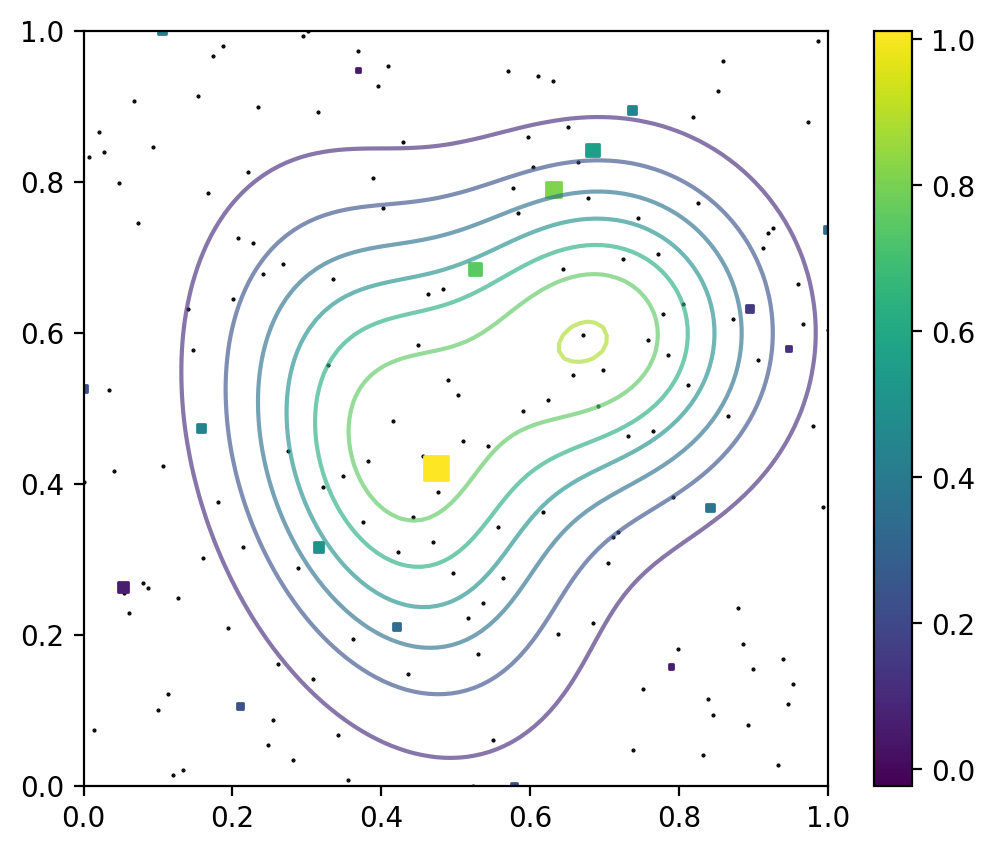

In [22]:
plt.figure(figsize=(6,5), dpi=200)

plt.contour(t,t,f(Xt),alpha=0.65)
plt.scatter(Xi[:,0],Xi[:,1], c='k', marker='.', s=1)

size = 1./(err/pred)
size = size/size.max()*75

plt.scatter(X[:,0],X[:,1], c=pred, marker='s', s=size)
plt.colorbar()

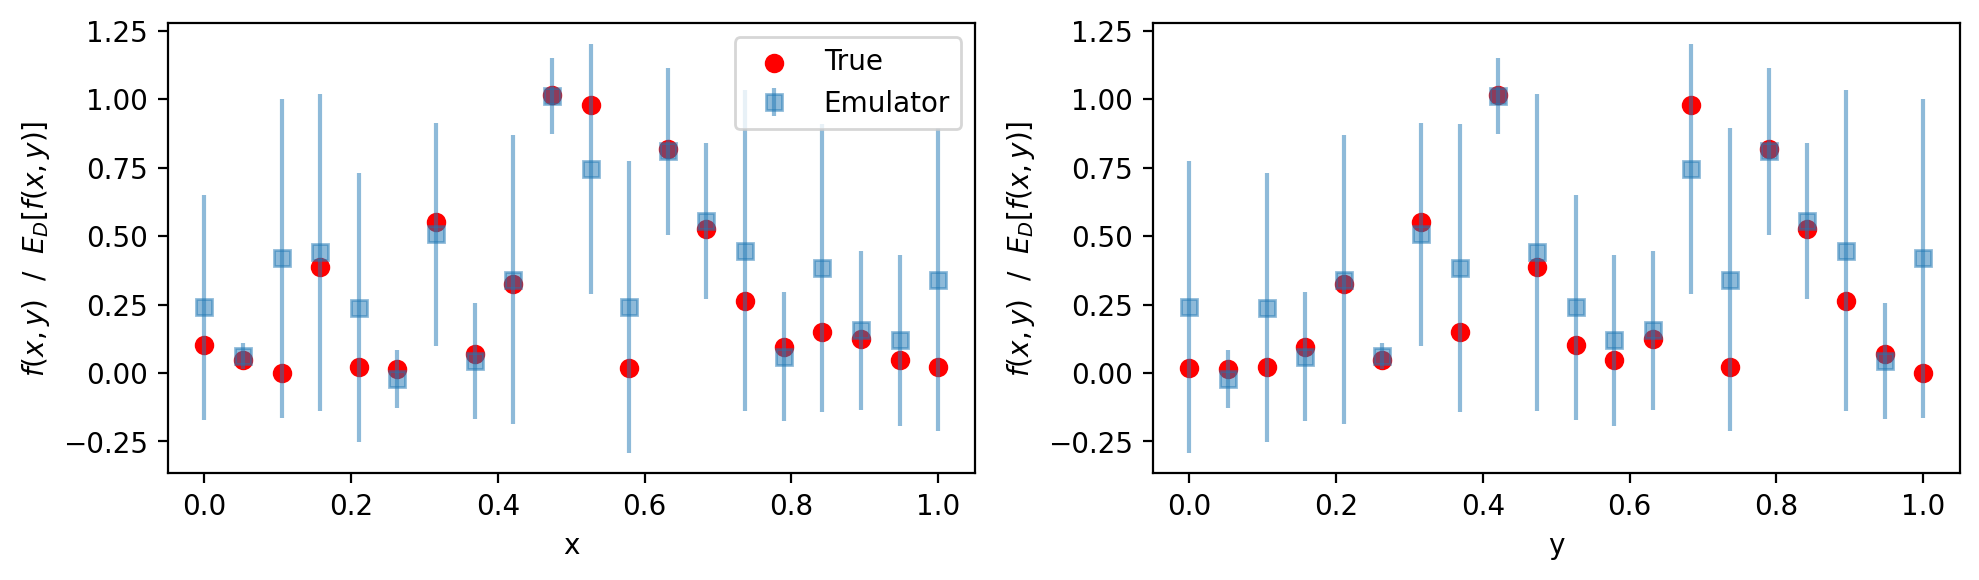

In [23]:
plt.figure(figsize=(10,3), dpi=200)
plt.subplot(121)
plt.scatter(X[:,0], f(X).ravel(),c='r', marker='o', label='True')
plt.errorbar(X[:,0], pred.ravel(), err.ravel(), 
             linestyle='none', marker='s', alpha=0.5, label='Emulator')
plt.xlabel('x')
plt.ylabel('$f(x,y)$  /  $E_D[f(x,y)]$')
plt.legend()
plt.subplot(122)
plt.scatter(X[:,1], f(X).ravel(),c='r', marker='o')
plt.errorbar(X[:,1], pred.ravel(), err.ravel(), 
             linestyle='none', marker='s', alpha=0.5)
plt.xlabel('y')
plt.ylabel('$f(x,y)$  /  $E_D[f(x,y)]$')
plt.tight_layout()
